In [13]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
% matplotlib inline

In [14]:
train = pd.read_json('../rawData/train_data.json')
test = pd.read_json('../rawData/test_data.json')

svm_tr = train.drop(['building_id','created','description','display_address','features',
                          'manager_id','photos','street_address'],axis=1)
svm_tr = svm_tr.sample(n=500)

X_svm_train, X_svm_test, y_svm_train, y_svm_test = train_test_split(svm_tr.drop(['interest_level'],axis=1),
                                                                    svm_tr['interest_level'], test_size=0.1, 
                                                                    random_state=42)
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_svm_train)

svm_model = SVC(cache_size=7000, decision_function_shape='multinominal', verbose=True)

In [15]:
C_range = np.logspace(-3, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(cache_size=7000), param_grid=param_grid, cv=cv)
grid.fit(X_svm_train, y_svm_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03]), 'C': array([  1.00000e-03,   1.21153e-02,   1.46780e-01,   1.77828e+00,
         2.15443e+01,   2.61016e+02,   3.16228e+03,   3.83119e+04,
         4.64159e+05,   5.62341e+06,   6.81292e+07,   8.25404e+08,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=Non

In [16]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 1.7782794100389228, 'gamma': 9.9999999999999995e-07} with a score of 0.73


In [17]:
# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

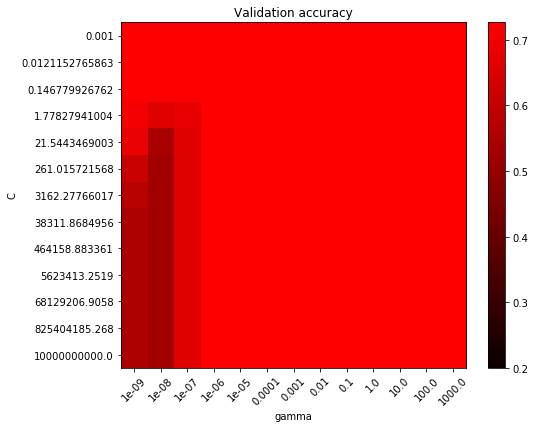

In [18]:
# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

C and gamma do impact the effectiveness of the SVM